In [1]:
import numpy as np
import csv
import matplotlib.pyplot as plt
from astropy.stats import jackknife_stats
import multiprocessing as mp
import time

In [2]:
# UNIFORM RANDOM DISTRIBUTION OF POINTS ON UNIT SPHERE.
def random_spin():
#     x = np.random.normal(0, 1, 3)
#     x = x/np.sqrt(x@x)
    p = np.random.random()
    if (p > 0.5):
        x = np.array([+1, 0, 0])
    else:
        x = np.array([-1, 0, 0])
    return x

# RETURN THE VALUE OF SPIN MAGNITUDE.
def spin(site):
    i_ = site[0]%n
    j_ = site[1]%n
    s = spin_config[i_][j_]
    if (len(s) == 3):
        spin_val = 1
    elif (len(s) == 2):
        spin_val = 0
        
    return spin_val

# RETURN ENERGY OF SINGLET
def energy_singlet(J):
    E_T = ((3*J)/4)*((np.exp(-beta*J) - 1)/(3*np.exp(-beta*J) + 1))
    return E_T

# INITIALIZE ENERGY OF THE SYSTEM.
def initialize_energy():
    Energy = 0
    for i in range(n):
        for j in range(n):
            Energy += (J1/4)*(dot(spin_config[i][j], spin_config[(i+1)%n][j]) + dot(spin_config[i][j],spin_config[i][(j+1)%n]))
            Energy += (J2/4)*(dot(spin_config[i][j], spin_config[(i+1)%n][(j+1)%n]) + dot(spin_config[i][j], spin_config[(i+1)%n][(j-1)%n]))
        
    return Energy

def calculate_energy():
    Energy = 0
    for i in range(n):
        for j in range(n):
            Energy += (J1/4)*(dot(spin_config[i][j], spin_config[(i+1)%n][j]) + dot(spin_config[i][j],spin_config[i][(j+1)%n]))
            Energy += (J2/4)*(dot(spin_config[i][j], spin_config[(i+1)%n][(j+1)%n]) + dot(spin_config[i][j], spin_config[(i+1)%n][(j-1)%n]))
    
    count_J1 = 0
    count_J2 = 0
    
    for i in range(n):
        for j in range(n):
            if (len(spin_config[i][j]) == 2):
                site1 = [i, j]
                site2 = spin_config[i][j]
                if (dist(site1, site2) == 1):
                    count_J1 +=1
                elif(dist(site1, site2) == 2):
                    count_J2 +=1
    
    Energy = Energy + (count_J1/2)*energy_singlet(J1) + (count_J2/2)*energy_singlet(J2)
    
    return Energy

In [3]:
# DOT PRODUCT DEFINITION

def dot(v1, v2):
    if (len(v1) == 3 and len(v2) == 3):
        dot_prod = v1@v2
    else:
        dot_prod = 0
        
    return dot_prod

# DISTANCES ON A TORUS

def dist(site1, site2):
    ix = site1[0]
    iy = site1[1]
    jx = site2[0]
    jy = site2[1]
    
    rx = abs(ix - jx)
    if (rx >= n/2):
        distancex = n - rx
    else:
        distancex = rx
        
    ry = abs(iy - jy)
    if (ry >= n/2):
        distancey = n - ry
    else:
        distancey = ry
    
    if (distancex == 0 or distancey == 0):
        distance = 1
        
    elif (distancex == 1 and distancey == 1):
        distance = 2
    
    else:
        print("Error?")
    
    return distance

In [4]:
def make_dimer(site):
    global E
    global spin_config

    ix = site[0]
    iy = site[1]
    
    unpaired_list = []
    for nbr in [[ix+1, iy], [ix-1, iy], [ix, iy+1], [ix, iy-1], [ix-1, iy-1], [ix-1, iy+1], [ix+1, iy-1], [ix+1, iy+1]]:
        if (spin(nbr) == 1):
            unpaired_list.append(nbr)
    
    if(len(unpaired_list)==0):
        return
    
    else:
        unpaired_indices = np.random.choice(len(unpaired_list))
        unpaired_data = unpaired_list[unpaired_indices]
        
        jx = unpaired_data[0]%n
        jy = unpaired_data[1]%n

        if (dist([ix, iy], [jx, jy]) == 1):
            J = J1
        elif(dist([ix, iy], [jx, jy]) == 2):
            J = J2

        # Calculate the change in energy if dimer is formed.
        E_1 = energy_singlet(J)
        E_2 = - (J1/4)*(dot(spin_config[ix][iy], spin_config[(ix-1)%n][iy]) + dot(spin_config[ix][iy], spin_config[(ix+1)%n][iy]) + dot(spin_config[ix][iy], spin_config[ix][(iy-1)%n]) + dot(spin_config[ix][iy], spin_config[ix][(iy+1)%n]) + dot(spin_config[jx][jy], spin_config[(jx-1)%n][jy]) + dot(spin_config[jx][jy], spin_config[(jx+1)%n][jy]) + dot(spin_config[jx][jy], spin_config[jx][(jy+1)%n]) + dot(spin_config[jx][jy], spin_config[jx][(jy-1)%n]))
        E_3 = - (J2/4)*(dot(spin_config[ix][iy], spin_config[(ix-1)%n][(iy-1)%n]) + dot(spin_config[ix][iy], spin_config[(ix+1)%n][(iy-1)%n]) + dot(spin_config[ix][iy], spin_config[(ix-1)%n][(iy+1)%n]) + dot(spin_config[ix][iy], spin_config[(ix+1)%n][(iy+1)%n]) + dot(spin_config[jx][jy], spin_config[(jx-1)%n][(jy-1)%n]) + dot(spin_config[jx][jy], spin_config[(jx+1)%n][(jy-1)%n]) + dot(spin_config[jx][jy], spin_config[(jx-1)%n][(jy+1)%n]) + dot(spin_config[jx][jy], spin_config[(jx+1)%n][(jy+1)%n]))
        #         E_3 = - (J2/4)*(dot(spin_config[ix], spin_config[(ix - 2)%n]) + dot(spin_config[ix], spin_config[(ix + 2)%n]) + dot(spin_config[jx], spin_config[(jx - 2)%n]) + dot(spin_config[jx], spin_config[(jx + 2)%n]))
        E_4 = (J/4)*(dot(spin_config[ix][iy], spin_config[jx][jy]))

        dE = E_1 + E_2 + E_3 + E_4

        # Metropolis implementation.

        p_accept = min(1, np.exp(-beta*dE))
        if (np.random.random() <= p_accept):
            spin_config[ix][iy] = [jx, jy]
            spin_config[jx][jy] = [ix, iy]
            E += dE

In [5]:
def spin_rotation(site):
    global E
    global spin_config

    ix = site[0]
    iy = site[1]
    
    spin_new = random_spin()
    dS = spin_new - spin_config[ix][iy]
    
    # Calculating change in E.
    dE1= (J1/4)*(dot(dS, spin_config[(ix - 1)%n][iy]) + dot(dS, spin_config[(ix + 1)%n][iy]) + dot(dS, spin_config[ix][(iy - 1)%n]) + dot(dS, spin_config[ix][(iy + 1)%n])) 
    dE2= (J2/4)*(dot(dS, spin_config[(ix - 1)%n][(iy - 1)%n]) + dot(dS, spin_config[(ix + 1)%n][(iy - 1)%n]) + dot(dS, spin_config[(ix - 1)%n][(iy + 1)%n]) + dot(dS, spin_config[(ix + 1)%n][(iy + 1)%n]))
    
    dE = dE1 + dE2
    # Metropolis implementation.
    
    p_accept = min(1, np.exp(-beta*dE))
    
#     print(dE, p_accept)
    if (np.random.random() <= p_accept):
        spin_config[ix][iy] = spin_new
        E += dE

In [6]:
def break_dimer(site):
    global E
    global spin_config

    ix = site[0]
    iy = site[1]
    
    jx = spin_config[ix][iy][0]
    jy = spin_config[ix][iy][1]
    
    if (dist([ix, iy], [jx, jy]) == 1):
        J = J1
    elif(dist([ix, iy], [jx, jy]) == 2):
        J = J2
     
    spin_config_new = np.copy(spin_config)

    # Modifying a copy of the spin configutation.
    
    spin_config_new[ix][iy] = random_spin()
    spin_config_new[jx][jy] = random_spin()
    
    # Calculate the change in energy if dimer is broken.
    E_1 = - energy_singlet(J) 
    E_2 = + (J1/4)*(dot(spin_config_new[ix][iy], spin_config_new[(ix-1)%n][iy]) + dot(spin_config_new[ix][iy], spin_config_new[(ix+1)%n][iy]) + dot(spin_config_new[ix][iy], spin_config_new[ix][(iy-1)%n]) + dot(spin_config_new[ix][iy], spin_config_new[ix][(iy+1)%n]) + dot(spin_config_new[jx][jy], spin_config_new[(jx-1)%n][jy]) + dot(spin_config_new[jx][jy], spin_config_new[(jx+1)%n][jy]) + dot(spin_config_new[jx][jy], spin_config_new[jx][(jy+1)%n]) + dot(spin_config_new[jx][jy], spin_config_new[jx][(jy-1)%n]))
    E_3 = + (J2/4)*(dot(spin_config_new[ix][iy], spin_config_new[(ix-1)%n][(iy-1)%n]) + dot(spin_config_new[ix][iy], spin_config_new[(ix+1)%n][(iy-1)%n]) + dot(spin_config_new[ix][iy], spin_config_new[(ix-1)%n][(iy+1)%n]) + dot(spin_config_new[ix][iy], spin_config_new[(ix+1)%n][(iy+1)%n]) + dot(spin_config_new[jx][jy], spin_config_new[(jx-1)%n][(jy-1)%n]) + dot(spin_config_new[jx][jy], spin_config_new[(jx+1)%n][(jy-1)%n]) + dot(spin_config_new[jx][jy], spin_config_new[(jx-1)%n][(jy+1)%n]) + dot(spin_config_new[jx][jy], spin_config_new[(jx+1)%n][(jy+1)%n]))
    E_4 = - (J/4)*(dot(spin_config_new[ix][iy], spin_config_new[jx][jy]))

    dE = E_1 + E_2 + E_3 + E_4
    
    # Metropolis implementation.
    
    p_accept = min(1, np.exp(-beta*dE))
    if (np.random.random() <= p_accept):
        spin_config[ix][iy] = spin_config_new[ix][iy]
        spin_config[jx][jy] = spin_config_new[jx][jy]
        E += dE

In [7]:
# MONTE CARLO SWEEP (RANDOM)

def monte_carlo_sweep():
    
    for i in range(n*n):
        
        ix = int(np.random.random()*n)
        iy = int(np.random.random()*n)
        
        site = [ix, iy]
        
        # f tunes the ratio of random spin rotations to dimer formation. Increase f to increase dimer formation.
        f = 0.25

        # If the chosen site has a free spin.
        if (spin(site) == 1):
            if (f <= np.random.random()):
                spin_rotation(site)
            else:
                make_dimer(site)

        # If the chosen site is part of a dimer.        
        elif (spin(site) == 0):
            break_dimer(site)

    # One MC Sweep Over.
            
    free_spins = []
    
    count_dimer = 0
    for i in range(n):
        for j in range(n):
            if (spin([i, j]) == 1):
                free_spins.append([i, j])
            else:
                count_dimer +=1
    
    if(len(free_spins)==0):
        iene = E/(n*n)
        stot = np.zeros((3), dtype=np.float64)
        mstag = np.zeros((3), dtype=np.float64)
        ndimer = count_dimer
    
        return iene, stot, mstag, ndimer
    
    else:
        S = np.zeros((3), dtype=np.float64)
        M_stag = np.zeros((3), dtype=np.float64)
        
        for sites in free_spins:
            S += np.array(spin_config[sites[0]][sites[1]])
            M_stag += np.array(spin_config[sites[0]][sites[1]])*((-1)**(sites[0]+sites[1]))

    iene = E/(n*n)
    stot = S/(n*n)
    mstag = M_stag/(n*n)
    ndimer = count_dimer

    return iene, stot, mstag, ndimer

In [8]:
# SIMULATION FUNCTION (INITIALIZE THE LATTICE BEFOREHAND)

def simulation(n, T, J2byJ1, nsweeps, anneal_str):
    
    global J2
    global beta
    
    J2 = J2byJ1*J1
    beta = 1/T
    
#     for i in range(n):
#         for j in range(n):
#             spin_config[i][j] = np.array([0.57735027, 0.57735027, 0.57735027])*((-1)**(i+j))
#             spin_config[i][j] = random_spin()

    global E 
    E = calculate_energy()

    E_list = []
    S_list = []
    M_list = []
    D_list = []
    
    neqsweeps = int(0.1*nsweeps)

    for i in range(nsweeps):
            E_meas, S_meas, M_meas, D_meas = monte_carlo_sweep()
            
            if (i > neqsweeps):
                E_list.append(E_meas)
                S_list.append(S_meas)
                M_list.append(M_meas)
                D_list.append(D_meas)
            
#             if(i%100 == 0):
#                 print(i)
                
    E_list = np.array(E_list)
    S_list = np.array(S_list)
    M_list = np.array(M_list)
    D_list = np.array(D_list)
    
    magS_list = np.sqrt(np.array(S_list).T[0]**2 + np.array(S_list).T[1]**2 + np.array(S_list).T[2]**2)
    magM_list = np.sqrt(np.array(M_list).T[0]**2 + np.array(M_list).T[1]**2 + np.array(M_list).T[2]**2)
    
#     plt.plot(E_list, '.-')
#     plt.xlabel("Monte Carlo time")
#     plt.ylabel(r'$E/n^2$')
#     plt.grid(True)
#     plt.show()

#     plt.plot(magS_list, '.-')
#     plt.xlabel("Monte Carlo time")
#     plt.ylabel(r'$S_z/n^2$')
#     # plt.ylim([-1,1])
#     plt.grid(True)
#     plt.show()
    
#     print(magS_list)
                
    test_statistic = np.mean
    
    avg_E, bias_E, stderr_E, conf_interval_E = jackknife_stats(E_list, test_statistic, 0.95)
    avg_S, bias_S, stderr_S, conf_interval_S = jackknife_stats(magS_list, test_statistic, 0.95)
    avg_M, bias_M, stderr_M, conf_interval_M = jackknife_stats(magM_list, test_statistic, 0.95)
    avg_D, bias_D, stderr_D, conf_interval_D = jackknife_stats(D_list, test_statistic, 0.95)
    
    data = [T, J2byJ1, avg_E, stderr_E, avg_S, stderr_S, avg_M, stderr_M, avg_D, stderr_D]
    
    with open("Ising_" + str(J2byJ1_list[0]) + "_L_" + str(n) + "_AFM_initial_" + str(anneal_str) + ".csv", 'a', newline='') as myfile:
        wr = csv.writer(myfile)
        wr.writerow(data)

In [11]:
# DEFINE THE LATTICE.

n = 10
J1 = 4
# T = 0.1
# J2byJ1 = 0.1
nsweeps = int(5.0e3)

T_list = np.arange(0.1, 4.1, 0.1)
# J2byJ1_list = np.arange(0.1, 1.1, 0.1)
J2byJ1_list = np.arange(0.01, 0.011, 0.2)

global spin_config
spin_config = np.zeros((n, n), dtype=np.ndarray)

for i in range(n):
    for j in range(n):
#         spin_config[i][j] = random_spin()
        spin_config[i][j] = np.array([1, 0, 0])*((-1)**(i+j))

In [12]:
with open("Ising_" + str(J2byJ1_list[0]) + "_L_" + str(n) + "_AFM_initial_" + "up" ".csv", 'w', newline='') as myfile:
        wr = csv.writer(myfile)

for J2byJ1 in J2byJ1_list:
    for T in T_list:
        simulation(n, T, J2byJ1, nsweeps, "up")

In [13]:
import csv
rows = []
with open("Ising_" + str(J2byJ1_list[0]) + "_L_" + str(n) + "_AFM_initial_" + "up" + ".csv", 'r') as file:
    csvreader = csv.reader(file)
    for row in csvreader:
        rows.append([float(i) for i in row])

energy_val = np.array(rows).T[2]
total_mag = np.array(rows).T[4]
staggered_magnetization = np.array(rows).T[6]
staggered_magnetization_err = np.array(rows).T[7]

no_of_dimers = np.array(rows).T[8]

# N = len(T_list)
# M = len(J2byJ1_list)

# staggered_magnetization = np.reshape(staggered_magnetization, (M,N)).T
# no_of_dimers = np.reshape(no_of_dimers, (M,N)).T

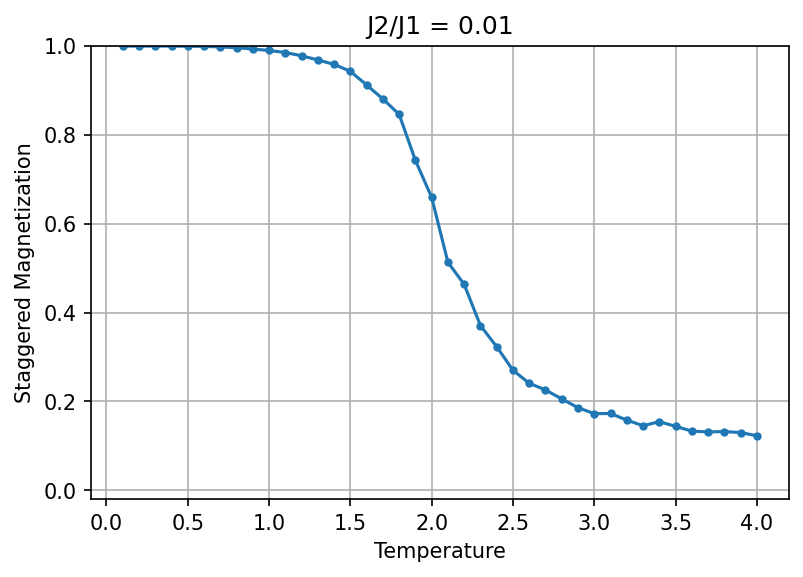

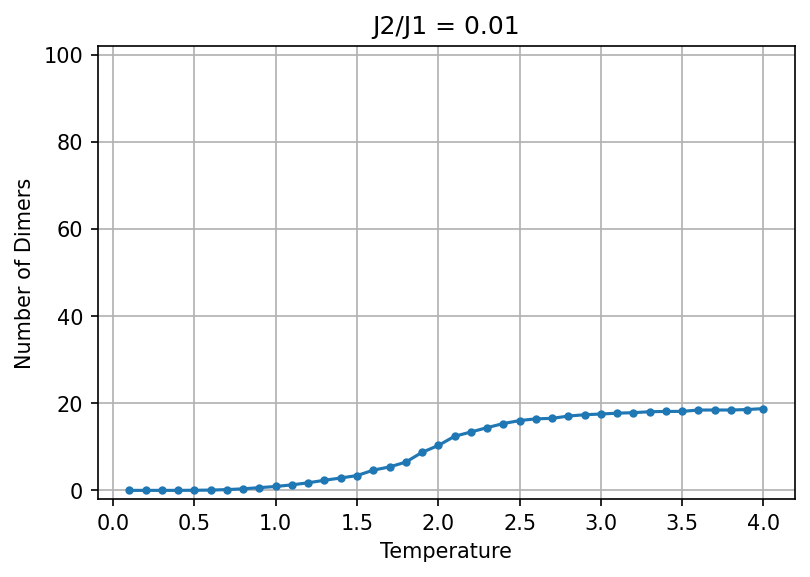

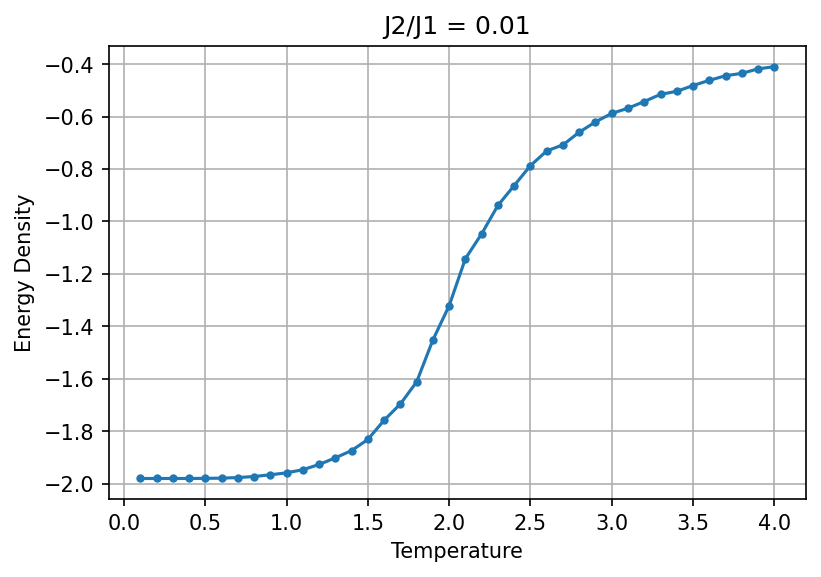

In [14]:
plt.figure(dpi=150)

plt.plot(T_list, staggered_magnetization, '.-' )
plt.xlabel("Temperature")
plt.ylabel("Staggered Magnetization")
plt.title("J2/J1 = " + str(J2byJ1_list[0]))
plt.grid(True)
plt.ylim([-0.02,1])
plt.show()

# plt.plot(T_list, total_mag, '.-' )
# plt.xlabel("Temperature")
# plt.ylabel("Net Magnetization")
# plt.title("J2/J1 = " + str(J2byJ1_list[0]))
# plt.grid(True)
# plt.ylim([-0.02,1])
# plt.show()

plt.figure(dpi=150)
plt.plot(T_list, no_of_dimers, '.-' )
plt.xlabel("Temperature")
plt.ylabel("Number of Dimers")
plt.title("J2/J1 = " + str(J2byJ1_list[0]))
plt.grid(True)
plt.ylim([-2,102])
plt.show()

plt.figure(dpi=150)
plt.plot(T_list, energy_val, '.-' )
plt.xlabel("Temperature")
plt.ylabel("Energy Density")
plt.title("J2/J1 = " + str(J2byJ1_list[0]))
plt.grid(True)
plt.show()

In [ ]:
import csv
rows1 = []
with open("J2byJ1_" + str(J2byJ1_list[0]) + "_L_" + str(n) + "_AFM_initial_" + "up" + ".csv", 'r') as file:
    csvreader = csv.reader(file)
    for row in csvreader:
        rows1.append([float(i) for i in row])

energy_val1 = np.array(rows1).T[2]
total_mag1 = np.array(rows1).T[4]
staggered_magnetization1 = np.array(rows1).T[6]
staggered_magnetization_err1 = np.array(rows1).T[7]

no_of_dimers1 = np.array(rows1).T[8]

# N = len(T_list)
# M = len(J2byJ1_list)

# staggered_magnetization = np.reshape(staggered_magnetization, (M,N)).T
# no_of_dimers = np.reshape(no_of_dimers, (M,N)).T

In [ ]:
plt.figure(dpi=150)

plt.plot(T_list, staggered_magnetization1, '.-' )
plt.xlabel("Temperature")
plt.ylabel("Staggered Magnetization")
plt.title("J2/J1 = " + str(J2byJ1_list[0]))
plt.grid(True)
plt.ylim([-0.02,1])
plt.show()

# plt.plot(T_list, total_mag, '.-' )
# plt.xlabel("Temperature")
# plt.ylabel("Net Magnetization")
# plt.title("J2/J1 = " + str(J2byJ1_list[0]))
# plt.grid(True)
# plt.ylim([-0.02,1])
# plt.show()

plt.figure(dpi=150)
plt.plot(T_list, no_of_dimers1, '.-' )
plt.xlabel("Temperature")
plt.ylabel("Number of Dimers")
plt.title("J2/J1 = " + str(J2byJ1_list[0]))
plt.grid(True)
plt.ylim([-2,102])
plt.show()

plt.figure(dpi=150)
plt.plot(T_list, energy_val1, '.-' )
plt.xlabel("Temperature")
plt.ylabel("Energy Density")
plt.title("J2/J1 = " + str(J2byJ1_list[0]))
plt.grid(True)
plt.show()

In [ ]:
plt.figure(dpi=150)
plt.plot(T_list, energy_val, '.-' , label = 'Ising spins')
plt.xlabel("Temperature")
plt.ylabel("Energy Density")
plt.title("J2/J1 = " + str(J2byJ1_list[0]))
plt.plot(T_list, energy_val1, '.-', label = '3D spins')
plt.xlabel("Temperature")
plt.ylabel("Energy Density")
plt.title("J2/J1 = " + str(J2byJ1_list[0]))
plt.grid(True)
plt.legend()
plt.show()